In [1]:
# ⚙️ 라이브러리 설치 (처음 한 번만)
!pip install transformers pandas scikit-learn torch tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
# ✅ 1. 데이터 불러오기 및 전처리
df = pd.read_csv("train.csv", encoding="ISO-8859-1")[["text", "sentiment"]]
df = df[df["sentiment"] != "neutral"]
label_map = {"negative": 0, "positive": 1}
df["label"] = df["sentiment"].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# ✅ 2. Tokenizer 및 Dataset
tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
# ✅ 3. DataLoader
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ✅ 4. 모델 및 옵티마이저
from transformers import BertModel
import torch.nn as nn

class CustomBertClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3, hidden_size=768, num_labels=2):
        super(CustomBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("kykim/bert-kor-base")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output  # [CLS] 토큰에 해당하는 출력
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels.to(logits.device))
        return type('Output', (), {'loss': loss, 'logits': logits})()  # BERT의 outputs처럼 객체화

model = CustomBertClassifier()
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

In [4]:
# ✅ 5. 학습/평가 함수
def train(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=["부정", "긍정"]))
    acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    return acc

In [5]:
# ✅ 6. 학습 실행
num_epochs = 10
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer)
    acc = evaluate(model, val_loader)
    train_losses.append(loss)
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1} | Loss: {loss:.4f} | Val Acc: {acc:.4f}")

100%|██████████| 819/819 [01:32<00:00,  8.85it/s]


              precision    recall  f1-score   support

          부정       0.79      0.89      0.84      1556
          긍정       0.89      0.78      0.83      1717

    accuracy                           0.84      3273
   macro avg       0.84      0.84      0.83      3273
weighted avg       0.84      0.84      0.83      3273

Epoch 1 | Loss: 0.5616 | Val Acc: 0.8350


100%|██████████| 819/819 [01:33<00:00,  8.79it/s]


              precision    recall  f1-score   support

          부정       0.84      0.89      0.86      1556
          긍정       0.90      0.85      0.87      1717

    accuracy                           0.87      3273
   macro avg       0.87      0.87      0.87      3273
weighted avg       0.87      0.87      0.87      3273

Epoch 2 | Loss: 0.3873 | Val Acc: 0.8674


100%|██████████| 819/819 [01:33<00:00,  8.77it/s]


              precision    recall  f1-score   support

          부정       0.87      0.89      0.88      1556
          긍정       0.89      0.87      0.88      1717

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273

Epoch 3 | Loss: 0.3335 | Val Acc: 0.8802


100%|██████████| 819/819 [01:33<00:00,  8.77it/s]


              precision    recall  f1-score   support

          부정       0.89      0.87      0.88      1556
          긍정       0.88      0.90      0.89      1717

    accuracy                           0.89      3273
   macro avg       0.89      0.88      0.88      3273
weighted avg       0.89      0.89      0.89      3273

Epoch 4 | Loss: 0.3028 | Val Acc: 0.8854


100%|██████████| 819/819 [01:33<00:00,  8.77it/s]


              precision    recall  f1-score   support

          부정       0.88      0.88      0.88      1556
          긍정       0.89      0.90      0.89      1717

    accuracy                           0.89      3273
   macro avg       0.89      0.89      0.89      3273
weighted avg       0.89      0.89      0.89      3273

Epoch 5 | Loss: 0.2722 | Val Acc: 0.8894


100%|██████████| 819/819 [01:32<00:00,  8.83it/s]


              precision    recall  f1-score   support

          부정       0.86      0.92      0.89      1556
          긍정       0.93      0.86      0.89      1717

    accuracy                           0.89      3273
   macro avg       0.89      0.89      0.89      3273
weighted avg       0.89      0.89      0.89      3273

Epoch 6 | Loss: 0.2449 | Val Acc: 0.8921


100%|██████████| 819/819 [01:32<00:00,  8.82it/s]


              precision    recall  f1-score   support

          부정       0.89      0.88      0.88      1556
          긍정       0.89      0.90      0.90      1717

    accuracy                           0.89      3273
   macro avg       0.89      0.89      0.89      3273
weighted avg       0.89      0.89      0.89      3273

Epoch 7 | Loss: 0.2280 | Val Acc: 0.8897


100%|██████████| 819/819 [01:32<00:00,  8.83it/s]


              precision    recall  f1-score   support

          부정       0.86      0.92      0.89      1556
          긍정       0.92      0.87      0.89      1717

    accuracy                           0.89      3273
   macro avg       0.89      0.89      0.89      3273
weighted avg       0.89      0.89      0.89      3273

Epoch 8 | Loss: 0.2081 | Val Acc: 0.8921


100%|██████████| 819/819 [01:33<00:00,  8.76it/s]


              precision    recall  f1-score   support

          부정       0.89      0.91      0.90      1556
          긍정       0.92      0.90      0.91      1717

    accuracy                           0.90      3273
   macro avg       0.90      0.90      0.90      3273
weighted avg       0.90      0.90      0.90      3273

Epoch 9 | Loss: 0.1935 | Val Acc: 0.9028


100%|██████████| 819/819 [01:32<00:00,  8.81it/s]


              precision    recall  f1-score   support

          부정       0.86      0.93      0.89      1556
          긍정       0.94      0.86      0.89      1717

    accuracy                           0.89      3273
   macro avg       0.90      0.90      0.89      3273
weighted avg       0.90      0.89      0.89      3273

Epoch 10 | Loss: 0.1806 | Val Acc: 0.8937


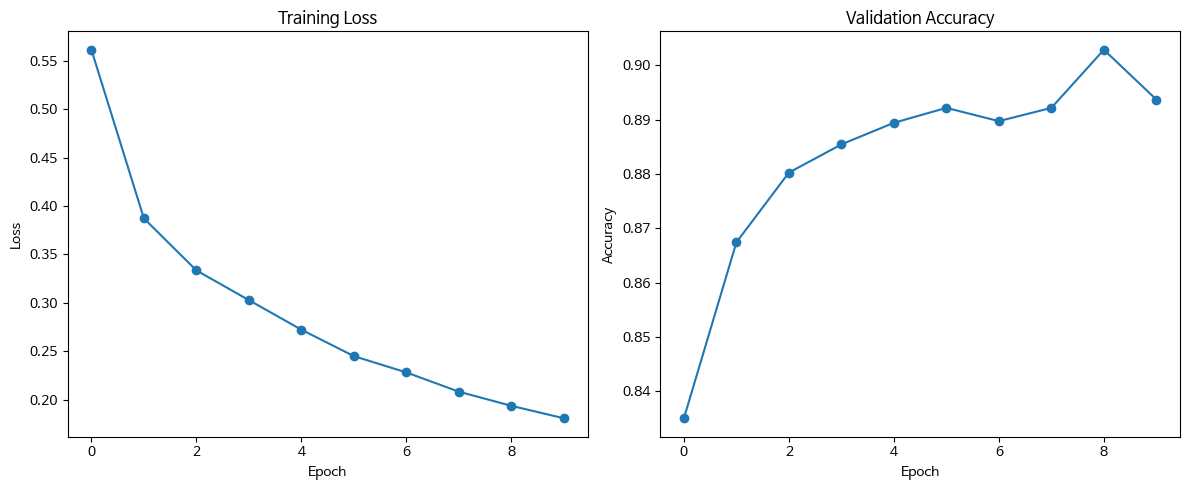

In [6]:
# ✅ 7. 학습 시각화
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [7]:
# ✅ 8. 모델 저장
model_path = "sentiment_model.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ 모델이 저장되었습니다: {model_path}")

✅ 모델이 저장되었습니다: sentiment_model.pt


In [8]:
# ✅ 9. 모델 불러오기 함수 (이걸 먼저!)
def load_model(model_path, num_labels=2):
    model = BertForSequenceClassification.from_pretrained("kykim/bert-kor-base", num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [9]:
# ✅ 10. 감정 분류 함수
def classify_emotion(model, text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**tokens).logits
    probs = F.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    labels = ["부정", "긍정"]
    print(f"문장: {text}")
    print(f"예측: {labels[pred]} (확률: {probs[0][pred]:.4f})")

In [10]:
# ✅ 11. 저장된 모델 불러와서 테스트
loaded_model = load_model(model_path)
classify_emotion(loaded_model, "이 영화는 정말 감동적이었어요.")
classify_emotion(loaded_model, "오늘 너무 피곤하고 짜증나.")
classify_emotion(loaded_model, "이거 다 장난이야, 별걸 다 해요.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


문장: 이 영화는 정말 감동적이었어요.
예측: 긍정 (확률: 0.8181)
문장: 오늘 너무 피곤하고 짜증나.
예측: 부정 (확률: 0.8504)
문장: 이거 다 장난이야, 별걸 다 해요.
예측: 부정 (확률: 0.6188)
